In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from torch.utils.data import random_split, SubsetRandomSampler, DataLoader
import matplotlib.pyplot as plt

In [7]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms


DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda:0


In [5]:
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))

1
0
NVIDIA GeForce GTX 1050 Ti


In [36]:
DATASET_NAME = "rene"

In [37]:
# Create normal trajectories dataset
normal_data_file = f"./data/{DATASET_NAME}/{DATASET_NAME}_gt_data.csv"
normal_data = np.genfromtxt(normal_data_file, delimiter=',')
# Remove the first column, which is the object_id
normal_data = normal_data[:, 1:]
print(f"Normal data shape: {normal_data.shape}")

# Create the generated abnormal dataset
abnormal_data_file = f"./data/{DATASET_NAME}/{DATASET_NAME}_gt_abnormal.csv"
abnormal_data = np.genfromtxt(abnormal_data_file, delimiter=',')
# Remove the first column, which is the object_id
abnormal_data = abnormal_data[:, 1:]
print(f"Abnormal data shape: {abnormal_data.shape}")

# Create the real abnormal datasets
real_abnormal_file = f"./data/{DATASET_NAME}/{DATASET_NAME}_gt_real_abnormal.csv"
real_abnormal_file_2 = f"./data/{DATASET_NAME}/{DATASET_NAME}_gt_real_abnormal_2.csv"
real_abnormal_data = np.genfromtxt(real_abnormal_file, delimiter=',')
real_abnormal_data_2 = np.genfromtxt(real_abnormal_file_2, delimiter=',')
# Remove the first column, which is the object_id
real_abnormal_data = real_abnormal_data[:, 1:]
real_abnormal_data_2 = real_abnormal_data_2[:, 1:]
print(f"Real abnormal data shape: {real_abnormal_data.shape}")
print(f"Real abnormal data 2 shape: {real_abnormal_data_2.shape}")

Normal data shape: (45341, 125)
Abnormal data shape: (82, 125)
Real abnormal data shape: (891, 125)
Real abnormal data 2 shape: (891, 125)


In [38]:
# Scale the data
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(normal_data)
train_data_scaled = torch.from_numpy(train_data_scaled).to(dtype=torch.float32)

test_data_scaled = scaler.fit_transform(abnormal_data)
test_data_scaled = torch.from_numpy(test_data_scaled).to(dtype=torch.float32)

test_data_real_scaled = scaler.fit_transform(real_abnormal_data)
test_data_real_scaled = torch.from_numpy(test_data_real_scaled).to(dtype=torch.float32)

test_data_real_scaled_2 = scaler.fit_transform(real_abnormal_data_2)
test_data_real_scaled_2 = torch.from_numpy(test_data_real_scaled_2).to(dtype=torch.float32)



# Split into training and validation
# train_data_scaled, validation_data_scaled = train_test_split(train_data_scaled, test_size=0.2)
# train_data_scaled = torch.from_numpy(train_data_scaled)
# validation_data_scaled = torch.from_numpy(validation_data_scaled)

# train_dataloader = torch.utils.data.DataLoader(train_data_scaled, batch_size=BATCH_SIZE, shuffle=True)
# validation_dataloader = torch.utils.data.DataLoader(validation_data_scaled, batch_size=BATCH_SIZE, shuffle=True)

In [39]:
# Define the DAE
class DAE(nn.Module):
    def __init__(self,
                 input_size,
                 hidden_layers=(16,),
                 hidden_activation=nn.ReLU,
                 output_activation=nn.Sigmoid
                 ):
        super(DAE, self).__init__()
        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.hidden_activation = hidden_activation
        self.output_activation = output_activation

        # Add the encoding layers
        self.encoded = self.create_layers(hidden_layers, input_size)

        # Add the decoding layers with the output activation function
        self.decoded = self.create_layers(hidden_layers[-2::-1], hidden_layers[-1])
        self.decoded.append(nn.Linear(hidden_layers[0], input_size))
        self.decoded.append(self.output_activation())

    def create_layers(self, design, input_size):
        layers = []
        for i, layer in enumerate(design):
            in_features = design[i-1] if i > 0 else input_size
            out_features = layer
            layers.append(nn.Linear(in_features, out_features))
            layers.append(self.hidden_activation())

        return nn.Sequential(*layers)

    def forward(self, input):
        encoded = self.encoded(input)
        # print(self.decoded)
        decoded = self.decoded(encoded)
        return decoded

In [40]:
# Define hyperparameters
BATCH_SIZE = 128
EPOCHS = 10
criterion = nn.MSELoss()
hidden_layers = (128,64,32,16,8)
learning_rate = 0.001

# Create the KFold object for cross validation
folds = 10
splits = KFold(n_splits=folds, shuffle=True, random_state=42)

In [41]:
# Define the model
model = DAE(input_size=train_data_scaled.shape[1], hidden_layers=hidden_layers).to(DEVICE)
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

In [42]:
### Get initial results on abnormal data before testing
model = model.cpu()
with torch.no_grad():
    # Compute a placeholder threshold
    output = model(train_data_scaled)
    assert output.shape == train_data_scaled.shape, "The predicted data shape is not right!"
    mse_per_sample = [mean_squared_error(train_data_scaled[i], output[i]) for i in range(output.shape[0])]
    normal_score = np.mean(mse_per_sample)
    threshold = normal_score + normal_score + 3 * (np.std(mse_per_sample) + np.std(mse_per_sample))

    # Test the abnormal data with the placeholder threshold
    output = model(test_data_scaled)
    mse_per_sample = [mean_squared_error(test_data_scaled[i], output[i]) for i in range(output.shape[0])]
    abnormal_test_ratio = sum([score > threshold for score in mse_per_sample])/float(len(mse_per_sample))
    print(f"Abnormal ratio: {abnormal_test_ratio}")
model = model.to(DEVICE)

Abnormal ratio: 0.0


In [43]:
print("Training the deep autoencoder")

history = {
    'train_score': [],
    'val_score': [],
    'train_loss': [],
    'val_loss': [],
    'threshold': [],
    'abnormal_ratio': []
}

for fold, (train_idx, val_idx) in enumerate(splits.split(train_data_scaled)):
    print(f"Fold {fold+1}")
    train_sampler = SubsetRandomSampler(train_idx)
    validation_sampler = SubsetRandomSampler(val_idx)
    train_dataloader = DataLoader(train_data_scaled, batch_size=BATCH_SIZE, sampler=train_sampler)
    validation_dataloader = DataLoader(train_data_scaled, batch_size=BATCH_SIZE, sampler=validation_sampler)

    # Train the model on the scaled data
    for epoch in range(EPOCHS):
        total_train_loss = 0
        total_validation_loss = 0
        print(f"Epoch {epoch}")
        for i, trajectories in enumerate(train_dataloader):
            trajectories = trajectories.to(DEVICE, dtype=torch.float32)
            # print(type(trajectories[0]))

            # Forward pass
            model.zero_grad()
            output = model(trajectories)
            loss = criterion(output, trajectories)
            total_train_loss += loss / len(train_dataloader)

            # Backward pass
            loss.backward()
            optimizer.step()

        history['train_loss'].append(total_train_loss.cpu())

        # Evaluate model at this epoch
        model.eval()
        model = model.cpu()
        with torch.no_grad():
            # Get the training score
            mse_per_sample_train = []
            for i, trajectories in enumerate(train_dataloader):
                output = model(trajectories)
                assert output.shape == trajectories.shape, "The predicted data shape is not right!"
                mse_per_sample_train.extend([mean_squared_error(trajectories[i], output[i]) for i in range(output.shape[0])])
            train_score = np.mean(mse_per_sample_train)
            print(f"Train score: {train_score}")
            history['train_score'].append(train_score)

            # Get validation score
            mse_per_sample_validation = []
            for i, trajectories in enumerate(validation_dataloader):
                output = model(trajectories)
                assert output.shape == trajectories.shape, "The predicted data shape is not right!"
                mse_per_sample_validation.extend([mean_squared_error(trajectories[i], output[i]) for i in range(output.shape[0])])

                # Also get loss for rating model
                loss = criterion(output, trajectories)
                total_validation_loss += loss / len(validation_dataloader)
            validation_score = np.mean(mse_per_sample_validation)
            print(f"Validation score: {validation_score}")
            history['val_score'].append(validation_score)
            history['val_loss'].append(total_validation_loss)

            # Calculate threshold
            threshold = train_score + validation_score + 3 * (np.std(mse_per_sample_train) + np.std(mse_per_sample_validation))
            print(f"Threshold value: {threshold}")
            history['threshold'].append(threshold)

            normal_train_ratio = sum([score < threshold for score in mse_per_sample_train])/float(len(mse_per_sample_train))
            print(f"Normal train ratio: {normal_train_ratio * 100}%")
            normal_valid_ratio = sum([score < threshold for score in mse_per_sample_validation])/float(len(mse_per_sample_validation))
            print(f"Normal validation ratio: {normal_valid_ratio * 100}%")

            # Get the ratio of correctly labeled abnormal data
            predicted_test_data = model(test_data_scaled)
            assert predicted_test_data.shape == test_data_scaled.shape, "The predicted data shape is not right!"
            mse_per_sample = [mean_squared_error(test_data_scaled[i], predicted_test_data[i]) for i in range(test_data_scaled.shape[0])]

            abnormal_test_ratio = sum([score > threshold for score in mse_per_sample])/float(len(mse_per_sample))
            print(f"Abnormal ratio: {abnormal_test_ratio * 100}%")
            history['abnormal_ratio'].append(abnormal_test_ratio)
        model = model.to(DEVICE)
        model.train()


Training the deep autoencoder
Fold 1
Epoch 0
Train score: 0.0037411577068269253
Validation score: 0.003862296463921666
Threshold value: 0.043700153939425945
Normal train ratio: 99.28441895799637%
Normal validation ratio: 99.11797133406836%
Abnormal ratio: 100.0%
Epoch 1
Train score: 0.002519030589610338
Validation score: 0.00255524436943233
Threshold value: 0.018751781899482012
Normal train ratio: 100.0%
Normal validation ratio: 100.0%
Abnormal ratio: 100.0%
Epoch 2
Train score: 0.0023457990027964115
Validation score: 0.0023814961314201355
Threshold value: 0.01770053943619132
Normal train ratio: 100.0%
Normal validation ratio: 100.0%
Abnormal ratio: 100.0%
Epoch 3
Train score: 0.0017349699046462774
Validation score: 0.0017696431605145335
Threshold value: 0.013283181469887495
Normal train ratio: 99.92158015978042%
Normal validation ratio: 99.84564498346197%
Abnormal ratio: 100.0%
Epoch 4
Train score: 0.0014960311818867922
Validation score: 0.001535408548079431
Threshold value: 0.0108242

In [44]:
print(threshold)
model = model.cpu()
model.eval()

0.018517307937145233


DAE(
  (encoded): Sequential(
    (0): Linear(in_features=125, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): ReLU()
    (8): Linear(in_features=16, out_features=8, bias=True)
    (9): ReLU()
  )
  (decoded): Sequential(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=125, bias=True)
    (9): Sigmoid()
  )
)

In [45]:
# Test model on normal data
with torch.no_grad():
    output = model(train_data_scaled)
    assert output.shape == train_data_scaled.shape, "The predicted data shape is not right!"
    mse_per_sample = [mean_squared_error(train_data_scaled[i], output[i]) for i in range(train_data_scaled.shape[0])]

    normal_test_ratio = sum([score < threshold for score in mse_per_sample])/float(len(mse_per_sample))
    print(f"Normal ratio: {normal_test_ratio * 100}%")

Normal ratio: 100.0%


In [46]:
# Test score on abnormal data
with torch.no_grad():
    predicted_test_data = model(test_data_scaled)
    assert predicted_test_data.shape == test_data_scaled.shape, "The predicted data shape is not right!"
    mse_per_sample = [mean_squared_error(test_data_scaled[i], predicted_test_data[i]) for i in range(test_data_scaled.shape[0])]

    abnormal_test_ratio = sum([score > threshold for score in mse_per_sample])/float(len(mse_per_sample))
    print(f"Abnormal ratio: {abnormal_test_ratio * 100}%")

Abnormal ratio: 98.78048780487805%


In [47]:
# Test score on real abnormal data
with torch.no_grad():
    predicted_test_data = model(test_data_real_scaled)
    assert predicted_test_data.shape == test_data_real_scaled.shape, "The predicted data shape is not right!"
    mse_per_sample = [mean_squared_error(test_data_real_scaled[i], predicted_test_data[i]) for i in range(test_data_real_scaled.shape[0])]

    abnormal_test_ratio = sum([score > threshold for score in mse_per_sample])/float(len(mse_per_sample))
    print(f"Real abnormal ratio: {abnormal_test_ratio * 100}%")

Real abnormal ratio: 43.65881032547699%


In [48]:
# Test score on real abnormal data 2
with torch.no_grad():
    predicted_test_data = model(test_data_real_scaled_2)
    assert predicted_test_data.shape == test_data_real_scaled_2.shape, "The predicted data shape is not right!"
    mse_per_sample = [mean_squared_error(test_data_real_scaled_2[i], predicted_test_data[i]) for i in range(test_data_real_scaled_2.shape[0])]

    abnormal_test_ratio = sum([score > threshold for score in mse_per_sample])/float(len(mse_per_sample))
    print(f"Real abnormal 2 ratio: {abnormal_test_ratio * 100}%")

Real abnormal 2 ratio: 21.773288439955106%


In [49]:
torch.save(model.state_dict(), "./models/rene_dae")
# model = torch.load("models/10_epochs")

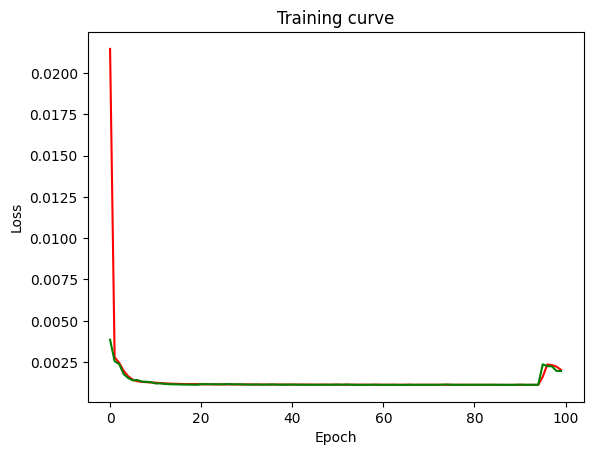

In [50]:
model = model.cpu()
model.eval()
with torch.no_grad():
    plt.title("Training curve")
    plt.plot(range(len(history['train_loss'])),history['train_loss'],'r')
    plt.plot(range(len(history['val_loss'])),history['val_loss'],'g')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

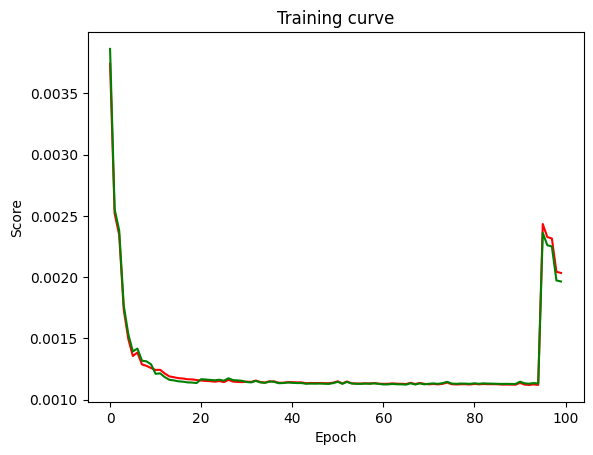

In [51]:
model = model.cpu()
model.eval()
with torch.no_grad():
    plt.title("Training curve")
    plt.plot(range(len(history['train_score'])),history['train_score'],'r')
    plt.plot(range(len(history['val_score'])),history['val_score'],'g')
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.show()

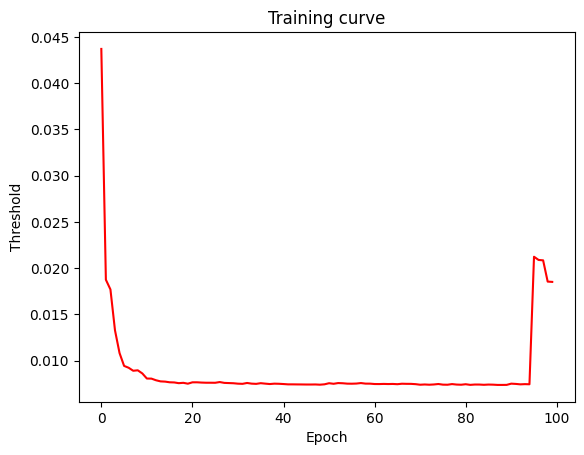

In [52]:
model = model.cpu()
model.eval()
with torch.no_grad():
    plt.title("Training curve")
    plt.plot(range(len(history['threshold'])),history['threshold'],'r')
    plt.xlabel("Epoch")
    plt.ylabel("Threshold")
    plt.show()